In [1]:
import rawpy
import imageio
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import numpy as np
from torchvision import models
from matplotlib import pyplot as plt
import torch
from torchsummary import summary
from collections import defaultdict
import torch.nn.functional as F
import torch
from torchsummary import summary
import torch
import torch.nn as nn
# from loss import dice_loss
from tqdm import tqdm
import random
import pickle

In [50]:
with open('/mnt/d/dng/raw_list.pkl','rb') as f:
    raw_list = pickle.load(f)
    raw_array = np.stack(raw_list)
    del raw_list
    raw_array[raw_array>255] = 255
    raw_array = raw_array.astype(np.float32)/255.0
with open('/mnt/d/dng/rgb_list.pkl','rb') as f:
    rgb_list = pickle.load(f)
    rgb_array = np.stack(rgb_list)
    del rgb_list

In [3]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(1, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        
        layer3 = self.layer3_1x1(layer3)
#         x = self.upsample(layer3)
#         print("x shape:",x.shape)
#         print("layer3 shape:",layer3.shape)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out



In [4]:
model = torch.load('resnet18_128_4l_03xx.pt')
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
tensor_norm = transforms.Compose([
transforms.Normalize([0.479], [0.212]) # dng
])

In [6]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [71]:
image_num = 48
tile_size = 64
big_raw = raw_array[image_num]
big_image = rgb_array[image_num]
rows = int(big_image.shape[0]/tile_size)
cols = int(big_image.shape[1]/tile_size)

In [72]:
#split raw into tiles, make batches, and asemble out_image from batches
batch_size = 128
tiles_tensors = torch.empty((rows*cols,tile_size,tile_size),dtype=torch.float32)
for rownum in range(rows):
    for colnum in  range(cols):
        tiles_tensors[rownum*cols+colnum] = torch.tensor(big_raw[tile_size*rownum:tile_size*(rownum+1),tile_size*colnum:tile_size*(colnum+1)])
norm_tensor = tensor_norm(tiles_tensors).unsqueeze(1)
out_tensors = torch.empty((rows*cols,3,tile_size,tile_size),dtype=torch.float32)
with torch.no_grad():
    for i in range(int(rows*cols/batch_size)):
        batch = norm_tensor[i*batch_size:(i+1)*batch_size]
        out_batch = model(batch.to(device))
        out_tensors[i*batch_size:(i+1)*batch_size] = out_batch
    last_batch_size = rows*cols%batch_size
    last_batch = norm_tensor[-last_batch_size:]
    last_out_batch = model(last_batch.to(device))
    out_tensors[-last_batch_size:] = last_out_batch
out_tensors = inv_normalize(out_tensors)

out_img = torch.zeros(big_image.shape,dtype=torch.float32)
for rownum in range(rows):
    for colnum in  range(cols):
        out_img[rownum*tile_size:(rownum+1)*tile_size,colnum*tile_size:(colnum+1)*tile_size] = out_tensors[rownum*cols+colnum].permute(1,2,0)
    

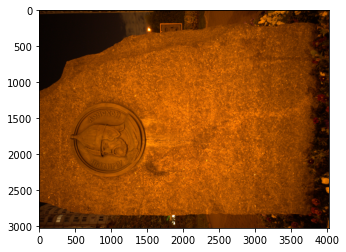

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


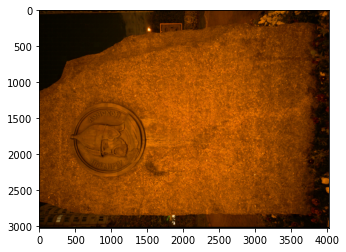

In [76]:
plt.imshow(big_image)
plt.show()
plt.imshow(out_img)

In [82]:
#save image
np_out = torch.clip(out_img*255,0,255).numpy().astype(np.uint8)
cv2_out= cv2.cvtColor(np_out, cv2.COLOR_BGR2RGB)
cv2_orig= cv2.cvtColor(big_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('img/original_big.png', cv2_orig)
cv2.imwrite('img/generated_big.png', cv2_out)

In [ ]:
#TODO last rows and colomns
right_side = big_image[:,-tile_size:]
right_side
bottom = big_image[-tile_size:]
bottom
plt.imshow(bottom)